from Kaggle:
https://www.kaggle.com/c/cat-in-the-dat/overview

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
np.random.seed(42)

TEST_SIZE = 0.2
N_SPLITS  = 5
SCORING = 'accuracy'

data_train = pd.read_csv('./data/train.csv',index_col='id')

X = data_train.drop(columns='target')
y = data_train.loc[:,'target']

<AxesSubplot:>

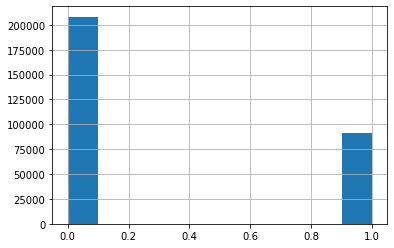

In [2]:
# A cara da saída
y.hist()

In [6]:
# não há dados faltantes, não há necessidade de imputar
dic = {}
for col in X:
    dic[col] = []
    dic[col].append(len(X[col].unique()))
    if len(X[col].unique()) < 100:
        dic[col].append(np.sort(X[col].unique()))
        dic[col].append(0)
    else:
        dic[col].append(np.sort(X[col].unique()))
        dic[col].append(1)
summary = pd.DataFrame.from_dict(data=dic, orient='index', columns=['Number of Cats','Cats', 'High Cardinality'])
print(summary)

       Number of Cats                                               Cats  \
bin_0               2                                             [0, 1]   
bin_1               2                                             [0, 1]   
bin_2               2                                             [0, 1]   
bin_3               2                                             [F, T]   
bin_4               2                                             [N, Y]   
nom_0               3                                 [Blue, Green, Red]   
nom_1               6  [Circle, Polygon, Square, Star, Trapezoid, Tri...   
nom_2               6          [Axolotl, Cat, Dog, Hamster, Lion, Snake]   
nom_3               6  [Canada, China, Costa Rica, Finland, India, Ru...   
nom_4               4                   [Bassoon, Oboe, Piano, Theremin]   
nom_5             222  [005dd4ce3, 037bd73d8, 05950689f, 05d5943a3, 0...   
nom_6             522  [0000ee65f, 00e9c15b8, 01455237a, 017eb57f0, 0...   
nom_7       

------------------------------------------------------------------
Cross-val Log_Reg com 5 folds
Mean: 67.52%
Std : 0.23%
Acc teste: 67.67%
------------------------------------------------------------------


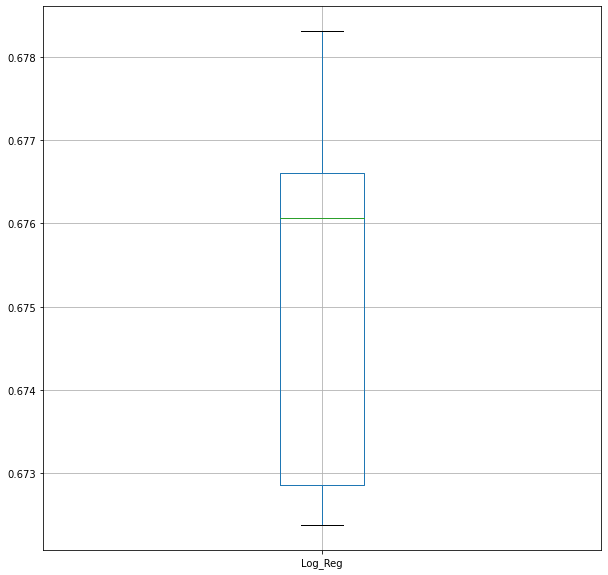

In [11]:
# Let's just ignore the high cardinality features
USE_COLS = summary[summary['High Cardinality']==0].index

X = X[USE_COLS]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

ohe = OneHotEncoder(categories='auto',sparse=False)

log_reg = LogisticRegression(C=0.19318569815283693, class_weight='balanced',max_iter=10000, solver='lbfgs', n_jobs=-1)
kfold = KFold(n_splits=N_SPLITS, shuffle=True)

# Ohe every column
cat_feat = USE_COLS
cat_transf = Pipeline([('Categorical',ohe)])

# preprocessador
preprocessor = ColumnTransformer(transformers=[
    ('Categorical', cat_transf, cat_feat)
])

# list models
list_models = [('Log_Reg', log_reg)] #('SVC', svc), , ('Grad_Boost', grad_boost)

df_scores = pd.DataFrame()

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    start_time = time.time()
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    print('------------------------------------------------------------------')
    print(f'Cross-val {name} com {N_SPLITS} folds')
    print(f'Mean: {scores.mean()*100:.2f}%')
    print(f'Std : {scores.std()*100:.2f}%')  
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'Acc teste: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print('------------------------------------------------------------------')
    print("Run time: %s seconds" % round((time.time() - start_time),1)) 

df_scores.boxplot(figsize=(10, 10))
plt.show()

In [12]:
# Gerando output pro Kaggle

test_data = pd.read_csv('./data/test.csv',index_col='id')

X_test_final = test_data[USE_COLS]

y_result_final = pipe.predict(X_test_final)
pd.DataFrame(data=y_result_final,index=X_test_final.index,columns=['target']).to_csv('mysubmission_2.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)

# instanciando
ohe = OneHotEncoder(categories='auto', sparse=False)
le = LabelEncoder()
orden = OrdinalEncoder()
#num_imputer = SimpleImputer(strategy=NUM_STRATEGY)
#cat_imputer = SimpleImputer(strategy=CAT_STRATEGY)
#scaler = StandardScaler()

svc = SVC()
log_reg = LogisticRegression()
grad_boost = GradientBoostingClassifier()
kfold = KFold(n_splits=N_SPLITS, shuffle=True)

# pipe binary
bin_feat = ['bin_0','bin_1','bin_2', 'bin_3', 'bin_4','day','month']
bin_transf = Pipeline([('Binnary', le)])

# pipe categoric low cardinality
cat_feat_low_card = ['nom_0', 'nom_1', 'nom_2','nom_3', 'nom_4','ord_0','ord_1','ord_2','ord_3','ord_4']
cat_transf_low_card = Pipeline([('OneHot', ohe)]) #

# pipe categoric high cardinality
cat_feat_high_card = ['nom_0', 'nom_1', 'nom_2','nom_3', 'nom_4','ord_5']
cat_transf_high_card = Pipeline([('LabelEncod', le)]) #

# preprocessador
preprocessor = ColumnTransformer(transformers=[
    ('Bin', bin_transf, bin_feat),
    ('CatLowCard', cat_transf_low_card, cat_feat_low_card),
    ('CatHighCard', cat_transf_high_card, cat_feat_high_card)
])
# list models
list_models = [('Log_Reg', log_reg)] #('SVC', svc), , ('Grad_Boost', grad_boost)

df_scores = pd.DataFrame()

# cross-val, treino e avalicao tudo num for
for name, model in list_models:
    pipe = Pipeline([('Preprocessor', preprocessor), (name, model)])
    scores = cross_val_score(pipe, X_train, y_train, scoring=SCORING, cv=kfold)
    df_scores.loc[:, name] = scores
    print('------------------------------------------------------------------')
    print(f'Cross-val {name} com {N_SPLITS} folds')
    print(f'Mean: {scores.mean()*100:.2f}%')
    print(f'Std : {scores.std()*100:.2f}%')  
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'Acc teste: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print('------------------------------------------------------------------')

df_scores.boxplot(figsize=(10, 10))
plt.show()

In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
bin_cols = ['bin_0','bin_1','bin_2', 'bin_3', 'bin_4']

# Para essas colunas é necessário trocar a letra por 1 ou 0
# Mas essa transformação tem que entrar no pipeline
make_num_bin = ['bin_3','bin_4']
bin_replace = {'bin_3':{'T':1,'F':0},'bin_4':{'Y':1,'N':0}}

for col in make_num_bin:
    data_train[col] = data_train[col].map(bin_replace[col])

In [ ]:
data_train.columns.values[5:-1]

In [ ]:
X = data_train.drop(columns='target')
cat_features = data_train.columns.values[5:-1]
X[cat_features].head()

In [ ]:
ohe = OneHotEncoder(sparse=False)
X_encoded = ohe.fit_transform(X[cat_features])

In [ ]:
X_encoded

## Usando o Label Encoder

In [ ]:
label = LabelEncoder()

In [ ]:
for c in  X.columns:
    if(X[c].dtype=='object'):
        X[c]=label.fit_transform(X[c])
    else:
        X[c]=X[c]

In [ ]:
label.fit_transform(data_train['nom_5'])

In [ ]:
ohe.fit_transform(data_train[['nom_5']]).shape

In [ ]:
data_train['nom_5'].unique()

In [ ]:
X.columns

## Usando onehotencoder


In [ ]:
ohe = OneHotEncoder()
ohe.fit(X)
X_encoded = ohe.transform(X)
X_encoded.shape

## Regressão Logística

In [ ]:
lr = LogisticRegression()
lr.fit(X,y)

In [ ]:
data_test = pd.read_csv('./data/test.csv',index_col='id')

X_test = data_test

for c in  X_test.columns:
    if(X_test[c].dtype=='object'):
        X_test[c]=label.fit_transform(X_test[c])
    else:
        X_test[c]=X_test[c]
        

In [ ]:
y_result = lr.predict(X_test)

In [ ]:
pd.DataFrame(data=y_result,index=X_test.index,columns=['target']).to_csv('output.csv')